# Unsupervised Learning

Unsupervised machine learning is a type of learning that occurs when we only have features $X = \{X_{ji}\}$ but not labels $y_j$. 

These algorithms typically revolve around clustering, i.e. assigning each row $X_{j \cdot}$ to a cluster $C_k$ such that the rows that share a cluster are more *similar* than ones from different clusters.  There are several ways to do this, some which require ground truth labeling and some which do not.  

Variations of unsupervised algorithms are often used for dimension reduction, example: random projections.

## Metrics for Unsupervised Learning

The simplest form is **Within Class Sum of Squares (WCSS)**, which is based on the 2nd moment of each cluster (mean centroids).  Let $\mu_k$ be the mean centroids of all rows in cluster $k$, i.e. for all elements $X_{j \cdot} \in C_k$,
$$\mu_k = \frac{1}{|C_k|} \sum_{X_{j \cdot} \in C_k} X_{j \cdot}.$$
Then the WCSS is defined as the corresponding sum for each cluster:
$$\sum_k \frac{1}{|C_k|} \sum_{X_{j \cdot} \in C_k} \| X_{j \cdot} - \mu_k\|^2_2\,.$$

Another metric is called the **Silhouette Coefficient**.  If $a_j$ is the mean distance between a point $X_{j \cdot}$ and the other points in the same cluster $C_k$ and $b_j$ is the mean is the distance between $X_{j \cdot}$ and the other points in the next nearest cluster $C_k'$, then the coefficient is given by
$$ \frac{b-a}{\max(a, b)}\,. $$

Assuming you have ground truth values $\tilde C_k$ and predicted classification labels $C_k$, it is easy to calculate their **Mutual Information**.  Mutual information has deep ties to information theory [see the Wikipedia article](http://en.wikipedia.org/wiki/Mutual_Information).  If $N$ is the total number of samples (number of rows of $X$), we can define the probabilities
$$ P_k = \frac{|C_k|}{N} \qquad \tilde P_k = \frac{|\tilde C_k|}{N} \qquad P_{k,l} = \frac{|C_k \cap \tilde C_l|}{N} $$
and then the mutual information is defined as
$$ \sum_{k, l} P_{k,l} \log\left(\frac{P_{k,l}}{ P_k \tilde P_l }\right)\,. $$

For more information on evaluation metrics for clustering algorithms, checkout the [Scikit Learn page on Clustering Metrics](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

In [12]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets

# Fit KMeans onto the Iris dataset
dataset = datasets.load_iris()
X = dataset.data
k_means = KMeans().fit(X)
y = k_means.predict(X)

# Compute Silhoutte score on clusters:
print "Silhouette Score", metrics.silhouette_score(X, y, metric='euclidean')

# Entropy
labels_true = [1, 1, 0, 1, 2, 2, 1, 2, 0]
labels_pred = [1, 0, 1, 1, 2, 1, 1, 2, 2]

print "Adjusted Mutual Information ", metrics.adjusted_mutual_info_score(labels_true, labels_pred)
print "Mutual Information ", metrics.mutual_info_score(labels_true, labels_pred)

Silhouette Score 0.351641137588
Adjusted Mutual Information  0.560826030402
Mutual Information  0.686961576597


# Clustering

## $K$-Means
The specification of $K$-means is simple: assign a collection of clusters $C_k$ that minimize the distances from samples to cluster centroids:

$$ \mbox{argmin}_C \sum_{k=1}^K \sum_{X_j \in C_k} \| X_{j\cdot} - \mu_k \|_2^2 $$

where $\mu_k$ is the center of the points in $C_k$.  The algorithm to implement this is simple:

1. Initialize $\mu_k$ (with possibly random values).  

Then iterate between:
   1. Assign $X_{j\cdot}$ to the cluster $C_k$ that minimizes $\|X_{j\cdot} - \mu_k\|_2^2$.
   1. Recompute $\mu_k$ by averaging over all the points $X_{j\cdot}$ in the cluster $C_k$.

Notice that both iterative steps lower the objective (the algorithm is greedy) and there are only a finite number of possible partisions of the points $X_{j\cdot}$ so the algorithm is gauranteed to converge.  The converged solution may not be globally optimal.

## Gaussian Mixture Models
We can generalize the notion of $K$-Means in two ways:
1. Instead of requiring that each $X_{j\cdot}$ strictly belong to a single $C_k$, we say it belongs to $C_k$ with a probability
1. Insteading of just having $\mu_k$ as a degree of freedom, we have the pair $(\mu_k, \Sigma_k)$

Then each $X_{j\cdot}$ is of type $k$ with probability proportional to
$$ p_k \exp \left( \frac{1}{2} (X_{j\cdot} - \mu_k) \cdot \Sigma_k^{-1}(X_{j\cdot} - \mu_k) \right) $$
where $p_k > 0$ is a proportionality constant.
While this is not strictly a clustering algorithm, it can be turned into one but choosing the probability cluster with the highest probability.

**Question**:
1. For KMeans, what happens if the features have very different scales?
1. Does this problem exist for Gaussian Mixture Models?

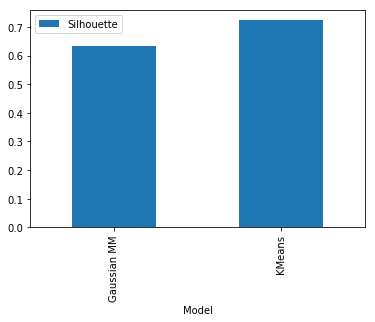

In [13]:
%matplotlib inline

from sklearn import cluster, mixture, datasets
import pandas as pd

# load Boston dataset
diabetes = datasets.load_boston()

columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSAT"]
X = pd.DataFrame(diabetes.data, columns=columns)
y = pd.Series(diabetes.target)

gmm_clf = mixture.GaussianMixture(n_components=3, random_state=42).fit(X)
kmeans_clf = cluster.KMeans(n_clusters=3, random_state=42).fit(X)

# Compute the Silhouette
pd.DataFrame([
    ("Gaussian MM",  metrics.silhouette_score(X, gmm_clf.predict(X), metric='euclidean')) ,
    ("KMeans",  metrics.silhouette_score(X, kmeans_clf.labels_, metric='euclidean'))
], columns=["Model", "Silhouette"]).plot(x="Model", y="Silhouette", kind="bar")


**Exercise**:
1. Normalize KMeans to improve performance use the scale function
1. Test the potential energy criterion from earlier and graph it in the above plots

# Spark ML

Spark ML is a Spark's machine learning library based on Dataframes (it superceeds MLlib, which is based on RDDs, and now being deprecated). Some parts of Spark ML - for instance, linear algebra - still call to RDD based API, BLAS wrappers.

Spark ML provides a standardized API for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline or workflow. Similarly to what you already know about `scikit-learn`.

## Basic components of a Pipeline

Basic components of the Pipeline (in the scikit-learn sense) are:
 1. Transformer: an abstract class to apply a transformation to dataset/dataframes
    1. `UnaryTransformer` abstract class: takes an input column, applies transformation, and output the result as a new column. The input and output columns can be arbitrary. However, in the Pipeline input column should be `features` output column should be named `prediction`.
    1. `UnaryTransofmer` has a `transform()` method

 1. Estimator: implements an algorithm which can be `fit` to a dataframe. For instance: a learning algorithm is an Estimator which is trained on a dataframe to produce a model.  
    1. Has a `fit()` method

1. Parameter: an API to pass parameters to Transformers and Estimators  

In Spark ML, `KMeans` algorithm is implemented as an Estimator which generates a `KMeansModel` as the base model.


In [17]:
#from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.clustering import BisectingKMeans, KMeans, GaussianMixture
from pyspark.ml.feature import HashingTF, Tokenizer, NGram, IDF, StopWordsRemover
from pyspark.sql import Row

The dataset we are going to use for this exercise comes from **Kaggle**: https://www.kaggle.com/datasets/?sortBy=votes&group=featured

It contains news articles on 2 topics, with associated label. We do not ahve to download it ourselves, as I have done it for you (along with some additional preprocessing).

In [123]:
import pandas as pd
data_df = pd.read_csv("data/Articles.csv",sep="|")

In [124]:
data_df.head()

,CleanedArticle,NewsType
0,KARACHI: The Sindh government has decided to b...,business
1,HONG KONG: Asian markets started 2015 on an up...,business
2,HONG KONG: Hong Kong shares opened 0.66 percen...,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,business
4,NEW YORK: US oil prices Monday slipped below $...,business


In [125]:
data_df.describe()

,CleanedArticle,NewsType
count,2692,2692
unique,2584,2
top,strong>KARACHI: Pakistan stocks ended at a rec...,sports
freq,5,1408


In [126]:
data = spark.read.options(header=True,inferSchema=True,delimiter="|").csv("file:///Users/alexey/Desktop/codas-ml/data/Articles.csv")

In [127]:
data.printSchema()

root
 |-- CleanedArticle: string (nullable = true)
 |-- NewsType: string (nullable = true)



In [128]:
data.show(5)

+--------------------+--------+
|      CleanedArticle|NewsType|
+--------------------+--------+
|KARACHI: The Sind...|business|
|"HONG KONG: Asian...|business|
|HONG KONG: Hong K...|business|
|"HONG KONG: Asian...|business|
|"NEW YORK: US oil...|business|
+--------------------+--------+
only showing top 5 rows



We are going to use a standard natural language processing workflow for feature extraction, followed by the k-means clustering into 3 clusters.


### Step 1.1.  Features: Bag of words (and variants)

Learning algorithms like vectors of numbers, not text.  The simplest way to turn a text into a vector of number is to treat the text as a "bag of words."  That is you

  - Split the text into words
  - Count how many times each word (/each word in some fixed vocabulary) occurs
  - _(Optionally)_ normalize the counts against some baseline
  - _(Variant)_ Just do a binary "yes / no" for whether each word (/.. in some vocabulary) is contained in the material
  
The output is a very large, but usually sparse, vector: The number of coordinates is the number of words in our dictionary, and the $i$-th coordinate entry is the number of occurances of the $i$-th word.

There's a reasonable implementation of this in the CountVectorizer class in `sklearn.feature_extraction.text`.  See http://scikit-learn.org/stable/modules/classes.html#text-feature-extraction-ref for more detail on the options.


#### Variation: Feature hashing

When doing "bag of words" type techniques on a *large* corpus and without an existing vocabulary, there is a simple trick that is often useful.  The issue (and solution) is as follows: 

 - The output is a feature vector, so that whenever we encounter a word we must look up which coordinate slot it is in.  A naive way would be to keep a list of all the words encoutered so far, and look up each word when it is encountered.  Whenever we encounter a new word, we see if we've already seen it before and if not -- assign it a new number.  This requires storing all the words that we have seen in memory, cannot be done in parallel (because we'd have to share the hash-table of seen words), etc.
 - A **hash function** takes as input something complicated (like a string) and spits out a number, with the desired property being that different inputs *usually* produce different outputs.  (This is how hash tables are implemented, as the name suggests.)
 - So -- rather than exactly looking up the coordinate of a given word, we can just use its hash value (modulo a big size that we choose).  This is fast and parallelizes easily.  (There are some downsides: You cannot tell, after the fact, what word each of your feature actually corresponds to!)
 
Scikit-learn includes `sklearn.feature_extraction.text.HashingVectorizer` to do this.  It behaves as almost a drop-in replacement for `CountVectorizer`.  It can be used with tf-idf by combining it with the `TfidfTransformer` (the `TfidfVectorizer` is the `CountVectorizer` together with the `TfidfTransformer`). For our application (where the training and test data is small), we may as well just use `TfidfVectorizer` -- but it is good to know that `HashingVectorizer` is there.


### Step 1.2 Stop words
It's common to want to __omit__ certain common words when doing these counts -- "a", "an", and "the" are common enough so that their counts do not tend to give us any hints as to the meaning of documents.  Such words that we want to omit are called __stop words__ (they don't stop anything, though).

NLTK contains a standard list of such stop words for English in `nltk.corpus.stopwords.words('english')`.  In our application, we'd also want to include "apple" -- it is certainly not going to help us distinguish our two meanings!

### Step 1.3 n-grams

Instead of looking at just single words, it is also useful to look at **n-grams**: These are n-word long sequences of words (i.e., each of "farmer's market", "market share", and "farm share" is a 2-gram).

The exact same sort of counting techniques apply.  The `CountVectorizer` function has built in support for this, too:

If you pass it the `ngram_range=(m, M)` then it will count $n$-grams with  $m \leq n \leq M$.

### Step 1.4 TF-IDF: term frequency–inverse document frequency

With single word vocabularies, we can probably do an okay job of coming up with a reasonable (if short) list of words that distinguish between the two documents.  With n-grams, even for $n=2$, it is better to let a computer help us.  

Just using frequencies, as above, is clearly not great.  Both apples the fruit and Apple the company are enjoyed around the world (one of the 2-grams that came up above!).  We would like to find words that are common in one document, not not common in all of them.  This is the goal of the __td-idf weighting__.  A precise definition is:

  1. If $d$ denotes a document and $t$ denotes a term, then the _raw term frequency_ $\mathrm{tf}^{raw}(t,d)$ is
  $$ \mathrm{tf}^{raw}(t,d) = \text{the number of times the term $t$ occurs in the document $d$} $$
  The vector of all term frequencies can optionally be _normalized_ either by dividing by the maximum of ny single word's occurance count ($L^1$) or by the Euclidean length of the vector of word occurance counts ($L^2$).  Scikit-learn by defaults does this second one:
  $$ \mathrm{tf}(t,d) = \mathrm{tf}^{L^2}(t,d) = \frac{\mathrm{tf}^{raw}(t,d)}{\sqrt{\sum_t \mathrm{tf}^{raw}(t,d)^2}} $$
  2. If $$ D = \left\{ d : d \in D \right\} $$ is the set of possible documents, then  the _inverse document frequency_ is
  $$ \mathrm{idf}^{naive}(t,D) = \log \frac{\# D}{\# \{d \in D : t \in d\}} \\
  = \log \frac{\text{count of all documents}}{\text{count of those documents containing the term $t$}} $$
  with a common variant being
  $$ \mathrm{idf}(t, D) = \log \frac{\# D}{1 + \# \{d \in D : t \in d\}} \\
   = \log \frac{\text{count of all documents}}{1 + \text{count of those documents containing the term $t$}} $$
  (This second one is the default in scikit-learn. Without this tweak we would omit the $1+$ in the denominator and have to worry about dividing by zero if $t$ is not found in any documents.)
  3. Finally, the weight that we assign to the term $t$ appearing in document $d$ and depending on the corpus of all documents $D$ is
  $$ \mathrm{tfidf}(t,d,D) = \mathrm{tf}(t,d) \mathrm{idf}(t,D) $$


Putting it all together in Spark ML is very simple:

In [137]:
# Configure an ML pipeline

tokenizer = Tokenizer(inputCol="CleanedArticle", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="filtered")   
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features",numFeatures=1048576)
#idf = IDF(inputCol=hashingTF.getOutputCol(),outputCol="features")

#Try KMeans and BisectingKMeans
kmeans = KMeans().setK(2).setSeed(1) #.setMaxIter(50)
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, kmeans])

# Fit the pipeline to training documents.
model = pipeline.fit(data)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(data)
selected = prediction.select("NewsType", "CleanedArticle", "prediction")

In [138]:
selected.show()

+--------+--------------------+----------+
|NewsType|      CleanedArticle|prediction|
+--------+--------------------+----------+
|business|KARACHI: The Sind...|         0|
|business|"HONG KONG: Asian...|         1|
|business|HONG KONG: Hong K...|         0|
|business|"HONG KONG: Asian...|         1|
|business|"NEW YORK: US oil...|         1|
|business|"New York: Oil pr...|         1|
|business|KARACHI: Strong b...|         0|
|business|"Singapore: Oil f...|         1|
|business|KARACHI: Wholesal...|         0|
|business|"SYDNEY: Oil pric...|         1|
|business|TOKYO: Tokyo stoc...|         1|
|business|HONG KONG: Hong K...|         0|
|business|"London: World oi...|         1|
|business|"ISLAMABAD: Long ...|         0|
|business|"SINGAPORE: Brent...|         1|
|business|ISLAMABAD: A two ...|         0|
|business|ISLAMABAD: The Na...|         0|
|business|"Hong Kong: Asian...|         1|
|business|ISLAMABAD: The Ec...|         0|
|business|"SINGAPORE: Saudi...|         1|
+--------+-

***Exercise***
 1. Add **IDF** weighting to the pipeline
 1. Try using `BisectingKMeans` instead of `KMeans` clustering

Next, we are going to try using n-grams instead of unigram features. And, perhaps, combine the two.
The changes to the code are minimal:

In [ ]:
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="filtered")   
ngram = NGram(n=2, inputCol=remover.getOutputCol(),outputCol="ngram")
hashingTF = HashingTF(inputCol=ngram.getOutputCol(), outputCol="bigrams",numFeatures=1048576)
#idf = IDF(inputCol=hashingTF.getOutputCol(),outputCol="features")

kmeans = KMeans().setK(4).setSeed(1) #.setMaxIter(50)
pipeline = Pipeline(stages=[tokenizer, remover, ngram, hashingTF, kmeans])

# Fit the pipeline to training documents.
model = pipeline.fit(data)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(data)
selected = prediction.select("id", "text", "prediction")
selected.show()

Finally, combine the two using the `VectorAssembler` (this will be more memory consuming):

In [16]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="filtered")   
ngram = NGram(n=2, inputCol=remover.getOutputCol(),outputCol="ngram")
hashingTF1 = HashingTF(inputCol=remover.getOutputCol(), outputCol="unigrams") #,numFeatures=1048576)
hashingTF2 = HashingTF(inputCol=ngram.getOutputCol(), outputCol="bigrams") #,numFeatures=1048576)
assembler = VectorAssembler(inputCols=["unigrams", "bigrams"], outputCol="features")
#idf = IDF(inputCol=hashingTF.getOutputCol(),outputCol="features")

kmeans = KMeans().setK(4).setSeed(1) #.setMaxIter(50)
pipeline = Pipeline(stages=[tokenizer, remover, ngram, hashingTF1, hashingTF2, assembler, kmeans])

# Fit the pipeline to training documents.
model = pipeline.fit(data)

# Make predictions on test documents and print columns of interest.
prediction = model.transform(data)
selected = prediction.select("id", "text", "prediction")
selected.show()